# Classification

## Get the data

In [15]:
# Fetch the MNIST dataset
from sklearn.datasets import fetch_openml

In [16]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [17]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [18]:
y.shape

(70000,)

In [19]:
# The images have 28*28 pixels
28*28

784

## Explore

In [20]:
import matplotlib as mpl
import matplotlib.pyplot as plt

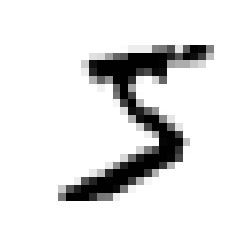

In [21]:
# Show the first image
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

In [22]:
# Check the label. It is indeed 5 as we see.
y[0]

'5'

In [23]:
import numpy as np

# Change the labels from string to int
y = y.astype(np.uint8)

### Split into test and train set
Since there are 10,000 images, we pick the first 60,000 images as the train set

In [43]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a binary classifier

In [44]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [45]:
# Use a SDG classifier (Effieicent for large dataset)
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [46]:
# Try to predict the image that we pick earlier
sgd_clf.predict([some_digit])

array([ True])

## Performance measure

### Cross-validation

In [47]:
# Crossvalidation implementation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.96355
0.93795
0.95615


In [48]:
# Use the cross_val_score directly
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3,
                scoring='accuracy')

array([0.96355, 0.93795, 0.95615])

In [49]:
# Make a self-defined estimator to predict everything false
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [50]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3,
                scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

By predicting everything to be False, it shows that it still has a high accuracy. Using this way, we can see that the accuracy is not always a good measure for the performance, especially when dealing with skewed data.

### Confusion matrix

In [51]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [52]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53057,  1522],
       [ 1325,  4096]])

The above confusion matrix has the following structure:

- Row is true condition: negative position
- Column is predict: negative position

So it is:

TN, FP  
FN, TP

In [54]:
# Precision
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.7290850836596654

In [55]:
# Recall
recall_score(y_train_5, y_train_pred)

0.7555801512636044

In [58]:
# F1 score
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7420962043663375

Set the threshold manually and see the result of classification

In [68]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2412.53175101])

In [69]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [70]:
threshold = 20000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [71]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                            method='decision_function')

In [83]:
y_scores

array([ 15132.03909617, -18996.62507   , -46067.2448135 , ...,
         4194.41832838,  -6817.73418657, -14231.49763697])

In [77]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = \
precision_recall_curve(y_train_5, y_scores)

In [81]:
def plot_precision_recal_vs_threshold(precisions, recalls, 
                                      thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='recall')
    plt.xlabel('threshold')
    plt.legend(loc='center left')
    plt.ylim([0, 1])

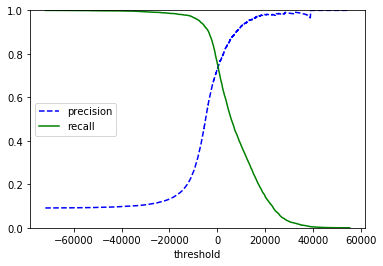

In [82]:
plot_precision_recal_vs_threshold(precisions, recalls, thresholds)

### ROC curve

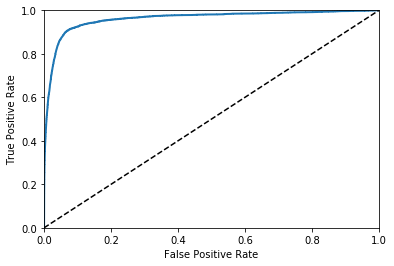

In [88]:
from sklearn.metrics import roc_curve

fpr, tpr, threshold = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

In [89]:
# AUC
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9611778893101814

Compare with random forest classifier using ROC curve.

In [92]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, 
                                   cv=3, method='predict_proba')

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [94]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = \
roc_curve(y_train_5, y_scores_forest)

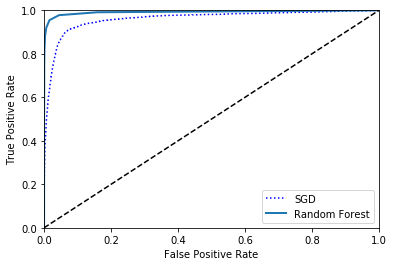

In [95]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

In [102]:
roc_auc_score(y_train_5, y_scores_forest)

0.9920527492698306

## Multiclass classification

In [106]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

In [108]:
# It returns 10 scores for this 10-class classifier
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-15955.22627845, -38080.96296175, -13326.66694897,
           573.52692379, -17680.6846644 ,   2412.53175101,
        -25526.86498156, -12290.15704709,  -7946.05205023,
        -10631.35888549]])

The highest score goes to class 5.

In [110]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [112]:
# We can force it to use the OvO strategey using SGDClassifier
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42, 
                                          max_iter=1000, tol=1e-3))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [113]:
len(ovo_clf.estimators_)

45

In [114]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([5], dtype=uint8)

In [115]:
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0. , 0.2, 0. , 0.8, 0. , 0. , 0. , 0. ]])

In [116]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.8489802 , 0.87129356, 0.86988048])

In [117]:
# Improve the performance by scaling the inputs
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3,
               scoring='accuracy')

array([0.89707059, 0.8960948 , 0.90693604])

## Error Analysis

In [118]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled,
                                y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5578,    0,   22,    7,    8,   45,   35,    5,  222,    1],
       [   0, 6410,   35,   26,    4,   44,    4,    8,  198,   13],
       [  28,   27, 5232,  100,   74,   27,   68,   37,  354,   11],
       [  23,   18,  115, 5254,    2,  209,   26,   38,  373,   73],
       [  11,   14,   45,   12, 5219,   11,   33,   26,  299,  172],
       [  26,   16,   31,  173,   54, 4484,   76,   14,  482,   65],
       [  31,   17,   45,    2,   42,   98, 5556,    3,  123,    1],
       [  20,   10,   53,   27,   50,   13,    3, 5696,  173,  220],
       [  17,   64,   47,   91,    3,  125,   24,   11, 5421,   48],
       [  24,   18,   29,   67,  116,   39,    1,  174,  329, 5152]])

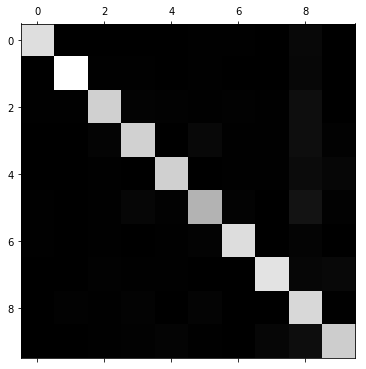

In [128]:
plt.figure(figsize=(6, 6))
plt.matshow(conf_mx, cmap=plt.cm.gray, fignum=1)
plt.show()

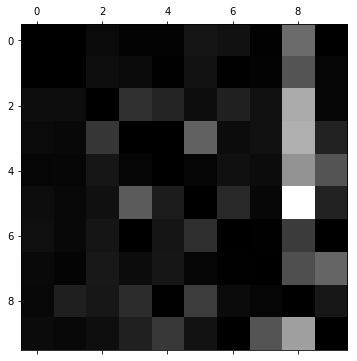

In [137]:
# Normalize with the total number of the digit
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

plt.figure(figsize=(6, 6))
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray, fignum=0)
plt.show()